## **Import Libraries**

In this section, we import essential libraries for data processing, model building, and evaluation:

- numpy and pandas: For handling numerical operations and data manipulation.
- tensorflow and tensorflow.keras: To build and train the Temporal Fusion Transformer (TFT) model.
- sklearn.preprocessing: Provides tools like LabelEncoder and MinMaxScaler to encode categorical data and scale numerical features.
- sklearn.model_selection: For splitting the dataset into training and testing sets.
- matplotlib.pyplot: For visualizing data trends and model performance.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## **Preparing Data**

Loads the energy consumption dataset from an Excel file into a DataFrame called **df**.

In [2]:
df = pd.read_excel('C:/Users/Abang Sano/miniconda3/Portofolio Github/Energy_Consumption_Dataset.xlsx')

**Extract Date and Time:**

- `df['date'] = df['TxnDate'].astype(str)`: Converts the transaction date to a string format and saves it in the date column.
- `df['current_time'] = df['TxnTime'].astype(str)`: Converts the transaction time to a string format and saves it in the `current_time` column.

In [3]:
df['date'] = df['TxnDate'].astype(str)
df['current_time'] = df['TxnTime'].astype(str)

**Combine Date and Time Columns:**

Merges the date and current_time columns into a single `datetime_str` column.

In [4]:
df['datetime_str'] = df['date'] + ' ' + df['current_time']

**Convert to Datetime Format:**

Converts the datetime_str column into a datetime column with a standard datetime format.

In [5]:
# Parse combined string into datetime
df['datetime'] = pd.to_datetime(
    df['datetime_str'],
    format='%d %b %Y %H:%M:%S'
)

**Sort by Date and Time:**

Sorts the data by the datetime column and resets the index.

In [6]:
# Sort values by datetime and reset index
df = df.sort_values('datetime').reset_index(drop=True)

**Create Time Index:**

Assigns a unique time index to each record for sequential analysis.

In [7]:
# Generating a time index for model training
df['time_idx'] = df.index

**Assign Group ID:**

Assigns a constant `group_id` to the series since we have a single time series in this dataset.

In [8]:
# Because i have single time series
df['group_id'] = 'series_1'  # Assign a constant group ID

**Extract Date/Time Features:**

Extracts hour, day of the week, and month from the datetime column to add as features.

In [9]:
# Rekayasa fitur
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

**Ensure Numerical Column Types:**

Converts specified columns to numeric data types to ensure compatibility for modeling.

In [10]:
# Ensure numerical columns are of correct type
numerical_columns = ['Consumption', 'hour', 'day_of_week', 'month', 'time_idx']
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric)

**Ensure Categorical Column Types:**
- `df[categorical_columns] = df[categorical_columns].astype(str)`: Ensures categorical columns are stored as strings.
- `df['time_idx'] = df['time_idx'].astype(int)`: Sets the `time_idx` column to integer type.
- `df = df.sort_values(['group_id', 'time_idx'])`: Sorts the DataFrame by `group_id` and `time_idx` to ensure proper ordering.

In [11]:
# Ensure categorical columns are of correct type
categorical_columns = ['group_id']
df[categorical_columns] = df[categorical_columns].astype(str)
df['time_idx'] = df['time_idx'].astype(int)
df = df.sort_values(['group_id', 'time_idx'])

In [12]:
df

,TxnDate,TxnTime,Consumption,date,current_time,datetime_str,datetime,time_idx,group_id,hour,day_of_week,month
0,01 Jan 2022,00:22:28,1.030,01 Jan 2022,00:22:28,01 Jan 2022 00:22:28,2022-01-01 00:22:28,0,series_1,0,5,1
1,01 Jan 2022,00:42:33,0.904,01 Jan 2022,00:42:33,01 Jan 2022 00:42:33,2022-01-01 00:42:33,1,series_1,0,5,1
2,01 Jan 2022,01:01:51,0.904,01 Jan 2022,01:01:51,01 Jan 2022 01:01:51,2022-01-01 01:01:51,2,series_1,1,5,1
3,01 Jan 2022,01:41:48,1.850,01 Jan 2022,01:41:48,01 Jan 2022 01:41:48,2022-01-01 01:41:48,3,series_1,1,5,1
4,01 Jan 2022,02:22:52,1.878,01 Jan 2022,02:22:52,01 Jan 2022 02:22:52,2022-01-01 02:22:52,4,series_1,2,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3601,28 Feb 2022,22:25:43,1.152,28 Feb 2022,22:25:43,28 Feb 2022 22:25:43,2022-02-28 22:25:43,3601,series_1,22,0,2
3602,28 Feb 2022,22:44:37,0.888,28 Feb 2022,22:44:37,28 Feb 2022 22:44:37,2022-02-28 22:44:37,3602,series_1,22,0,2
3603,28 Feb 2022,23:07:15,1.064,28 Feb 2022,23:07:15,28 Feb 2022 23:07:15,2022-02-28 23:07:15,3603,series_1,23,0,2
3604,28 Feb 2022,23:29:13,1.036,28 Feb 2022,23:29:13,28 Feb 2022 23:29:13,2022-02-28 23:29:13,3604,series_1,23,0,2


In [13]:
df.info

<bound method DataFrame.info of           TxnDate   TxnTime  Consumption         date current_time  \
0     01 Jan 2022  00:22:28        1.030  01 Jan 2022     00:22:28   
1     01 Jan 2022  00:42:33        0.904  01 Jan 2022     00:42:33   
2     01 Jan 2022  01:01:51        0.904  01 Jan 2022     01:01:51   
3     01 Jan 2022  01:41:48        1.850  01 Jan 2022     01:41:48   
4     01 Jan 2022  02:22:52        1.878  01 Jan 2022     02:22:52   
...           ...       ...          ...          ...          ...   
3601  28 Feb 2022  22:25:43        1.152  28 Feb 2022     22:25:43   
3602  28 Feb 2022  22:44:37        0.888  28 Feb 2022     22:44:37   
3603  28 Feb 2022  23:07:15        1.064  28 Feb 2022     23:07:15   
3604  28 Feb 2022  23:29:13        1.036  28 Feb 2022     23:29:13   
3605  28 Feb 2022  23:50:27        1.000  28 Feb 2022     23:50:27   

              datetime_str            datetime  time_idx  group_id  hour  \
0     01 Jan 2022 00:22:28 2022-01-01 00:22:28     

**Checking for Missing Values:**

This checks for any columns with missing values and prints them out if found. It helps in identifying gaps in the data that may need to be handled.

In [14]:
empty_columns = df.isnull().sum()
empty_columns = empty_columns[empty_columns > 0]
print(empty_columns)

Series([], dtype: int64)


**Defining Training and Validation Groups:**

This divides the dataset into training and validation sets. The 80th percentile of `time_idx` is used as the cutoff point, creating a time-based split

In [15]:
# Define training and validation groups
train_groups = [f'Group_{i}' for i in range(1, 9)]   # Groups 1-8 for training
val_groups = [f'Group_{i}' for i in range(9, 11)]    # Groups 9-10 for validation

# Determine the cutoff point for the split
cutoff_time = df['time_idx'].quantile(0.8)  # Use 80% of data for training

# Create training and validation DataFrames
train_df = df[df['time_idx'] <= cutoff_time].reset_index(drop=True)
val_df = df[df['time_idx'] > cutoff_time].reset_index(drop=True)

In [16]:
print("train_df shape:", train_df.shape)
print("train_df columns:", train_df.columns)
print("First few rows of train_df:")
print(train_df.head())

train_df shape: (2885, 12)
train_df columns: Index(['TxnDate', 'TxnTime', 'Consumption', 'date', 'current_time',
       'datetime_str', 'datetime', 'time_idx', 'group_id', 'hour',
       'day_of_week', 'month'],
      dtype='object')
First few rows of train_df:
       TxnDate   TxnTime  Consumption         date current_time  \
0  01 Jan 2022  00:22:28        1.030  01 Jan 2022     00:22:28   
1  01 Jan 2022  00:42:33        0.904  01 Jan 2022     00:42:33   
2  01 Jan 2022  01:01:51        0.904  01 Jan 2022     01:01:51   
3  01 Jan 2022  01:41:48        1.850  01 Jan 2022     01:41:48   
4  01 Jan 2022  02:22:52        1.878  01 Jan 2022     02:22:52   

           datetime_str            datetime  time_idx  group_id  hour  \
0  01 Jan 2022 00:22:28 2022-01-01 00:22:28         0  series_1     0   
1  01 Jan 2022 00:42:33 2022-01-01 00:42:33         1  series_1     0   
2  01 Jan 2022 01:01:51 2022-01-01 01:01:51         2  series_1     1   
3  01 Jan 2022 01:41:48 2022-01-01 01:41:48

In [17]:
print("\nval_df shape:", val_df.shape)
print("val_df columns:", val_df.columns)
print("First few rows of val_df:")
print(val_df.head())


val_df shape: (721, 12)
val_df columns: Index(['TxnDate', 'TxnTime', 'Consumption', 'date', 'current_time',
       'datetime_str', 'datetime', 'time_idx', 'group_id', 'hour',
       'day_of_week', 'month'],
      dtype='object')
First few rows of val_df:
       TxnDate   TxnTime  Consumption         date current_time  \
0  16 Feb 2022  23:09:17        4.984  16 Feb 2022     23:09:17   
1  16 Feb 2022  23:28:50        4.874  16 Feb 2022     23:28:50   
2  16 Feb 2022  23:49:35        4.662  16 Feb 2022     23:49:35   
3  17 Feb 2022  00:11:41        4.118  17 Feb 2022     00:11:41   
4  17 Feb 2022  00:30:29        1.968  17 Feb 2022     00:30:29   

           datetime_str            datetime  time_idx  group_id  hour  \
0  16 Feb 2022 23:09:17 2022-02-16 23:09:17      2885  series_1    23   
1  16 Feb 2022 23:28:50 2022-02-16 23:28:50      2886  series_1    23   
2  16 Feb 2022 23:49:35 2022-02-16 23:49:35      2887  series_1    23   
3  17 Feb 2022 00:11:41 2022-02-17 00:11:41      

In [18]:
# Check unique group IDs in the DataFrame
print("Unique group_ids in df:", df['group_id'].unique())

Unique group_ids in df: ['series_1']


In [19]:
# Print the training and validation group IDs
print("train_groups:", train_groups)
print("val_groups:", val_groups)

train_groups: ['Group_1', 'Group_2', 'Group_3', 'Group_4', 'Group_5', 'Group_6', 'Group_7', 'Group_8']
val_groups: ['Group_9', 'Group_10']


**Encoding and Normalizing Data:**
- The `group_id` column is encoded using `LabelEncoder` for use in the model.
- `Consumption` is normalized using `MinMaxScaler` to scale values between 0 and 1, making it easier for the model to train.

In [20]:
# Encode 'group_id'
le_group = LabelEncoder()
train_df['group_id_enc'] = le_group.fit_transform(train_df['group_id'])
val_df['group_id_enc'] = le_group.transform(val_df['group_id'])

# Normalize continuous variables
scaler = MinMaxScaler()
train_df['Consumption'] = scaler.fit_transform(train_df[['Consumption']])
val_df['Consumption'] = scaler.transform(val_df[['Consumption']])

**Setting Feature and Target Variables:**

Defines the features (independent variables) and target (dependent variable) for training the model.

In [21]:
features = ['time_idx', 'group_id_enc', 'hour', 'day_of_week', 'month']
target = 'Consumption'

## **Building TFT Model with Keras**

**Variable Selection Network:**

A custom neural network layer that learns to select important features dynamically for each time step. This layer applies embeddings to each variable and then uses a weighting mechanism to emphasize significant features.

In [22]:
class VariableSelectionNetwork(layers.Layer):
    def __init__(self, units, **kwargs):
        super(VariableSelectionNetwork, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.num_features = input_shape[-1]
        # Embedding layer for all variables
        self.embedding_layer = layers.TimeDistributed(
            layers.Dense(self.units * self.num_features)
        )
        # Weighting layer
        self.weight_layer = layers.TimeDistributed(
            layers.Dense(self.num_features, activation='softmax')
        )

    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, num_features)
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]

        # Compute embeddings
        embeddings = self.embedding_layer(inputs)
        embeddings = tf.reshape(
            embeddings, (batch_size, time_steps, self.num_features, self.units)
        )  # shape: (batch_size, time_steps, num_features, units)

        # Compute weights
        weights = self.weight_layer(inputs)  # shape: (batch_size, time_steps, num_features)
        weights = tf.expand_dims(weights, axis=-1)  # shape: (batch_size, time_steps, num_features, 1)

        # Weighted sum over variables (features)
        outputs = tf.reduce_sum(weights * embeddings, axis=2)  # shape: (batch_size, time_steps, units)
        return outputs

**Gated Residual Network:**

Another custom layer designed to capture complex interactions in the data. It applies a residual connection (combining original and transformed inputs) with a gating mechanism to control the flow of information through the network.

In [23]:
class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate=0.1, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate

        self.dense1 = layers.Dense(units, activation='elu')
        self.dense2 = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.layer_norm = layers.LayerNormalization()
        self.gate = layers.Dense(units, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dropout(x)
        x = self.dense2(x)
        gated_output = self.gate(x)
        x = x * gated_output
        x = self.layer_norm(inputs + x)
        return x

**Defining Time Series Input Shapes:**

Specifies the input shapes for historical and future time steps, setting up the structure for how past and future data will be fed into the model.

In [24]:
# Time series inputs
history_steps = 24  # Number of past time steps
future_steps = 1    # Number of future time steps to predict

# Input shapes
num_features = len(features)

# Define inputs
history_inputs = layers.Input(shape=(history_steps, num_features), name='history_inputs')
future_inputs = layers.Input(shape=(future_steps, num_features), name='future_inputs')

**Static Input and Embedding:**

Embeds static (unchanging) input features (like `group_id`). The embedding allows the model to learn a compact representation of the static feature, improving model performance.

In [25]:
# Static Input and Embedding
static_input = layers.Input(shape=(1,), name='static_input')
static_embedding = layers.Embedding(
    input_dim=train_df['group_id_enc'].nunique(), 
    output_dim=16
)(static_input)
static_embedding = layers.Flatten()(static_embedding)  # Shape: (batch_size, embedding_dim)

**Variable Selection for History and Future Inputs:**

Applies the Variable Selection Network to both historical and future inputs, enabling the model to learn which features are most relevant for predictions.

In [26]:
# Variable Selection for past inputs
history_vsn = VariableSelectionNetwork(units=16)(history_inputs)

# Variable Selection for future inputs
future_vsn = VariableSelectionNetwork(units=16)(future_inputs)

**Repeating Static Embeddings:**

Repeats the static embedding so it can be concatenated with the time-series data for each time step, allowing the model to leverage both time-series and static information.

In [27]:
# Repeat static embedding to match history and future steps
static_embedding_repeated_history = layers.RepeatVector(history_steps)(static_embedding)
static_embedding_repeated_future = layers.RepeatVector(future_steps)(static_embedding)

In [28]:
print("history_vsn shape:", history_vsn.shape)  # Expected: (None, history_steps, units)
print("static_embedding_repeated_history shape:", static_embedding_repeated_history.shape)  # Expected: (None, history_steps, embedding_dim)

history_vsn shape: (None, 24, 16)
static_embedding_repeated_history shape: (None, 24, 16)


**Concatenate Static Embeddings with Temporal Features:**

Combines the static embeddings (like group ID) with temporal features (historical and future variables) to provide the model with both static and dynamic information for each time step.

In [29]:
# Concatenate static embeddings with temporal features
history_combined = layers.Concatenate(axis=-1)([history_vsn, static_embedding_repeated_history])
future_combined = layers.Concatenate(axis=-1)([future_vsn, static_embedding_repeated_future])

**Pass through LSTM Layers:**

Applies an LSTM layer to both the historical and future combined features, allowing the model to capture temporal dependencies in the data.

In [30]:
# Pass through LSTM layers
lstm_layer = layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
history_lstm = lstm_layer(history_combined)
future_lstm = lstm_layer(future_combined)

**Combine Past and Future and Apply Attention:**

Concatenates historical and future LSTM outputs, then applies Multi-Head Attention to enhance feature relationships by focusing on relevant parts of the sequence.

In [31]:
# Combine past and future
encoder_output = layers.Concatenate(axis=1)([history_lstm, future_lstm])

# Multi-Head Attention
attention_output = layers.MultiHeadAttention(num_heads=32, key_dim=128)(encoder_output, encoder_output)

**Flatten and Pass through Dense Layers:**

Flattens the output of the attention layer, then passes it through dense layers to reduce dimensions and produce the final prediction output.

In [32]:
# Flatten and pass through Dense layers
flattened = layers.Flatten()(attention_output)
dense_output = layers.Dense(
    16, 
    activation='relu', 
    kernel_regularizer=regularizers.l2(0.01)
)(flattened)
final_output = layers.Dense(future_steps)(dense_output)

**Define and Compile the Model:**

Defines the model structure with input and output layers, then compiles it using Mean Squared Error (MSE) as the loss function, suitable for regression tasks.

In [33]:
def scheduler(epoch, lr):
    decay_rate = 0.96
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

In [34]:
lr_scheduler = LearningRateScheduler(scheduler)

In [35]:
model = models.Model(inputs=[history_inputs, future_inputs, static_input], outputs=final_output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ static_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 16)             │              16 │ static_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ history_inputs (InputLayer)   │ (None, 24, 5)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 16)                │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ future_inputs (InputLayer)    │ (None, 1, 5)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ variable_selection_network    │ (None, 24, 16)            │             510 │ history_inputs[0][0]       │
│ (VariableSelectionNetwork)    │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ repeat_vector (RepeatVector)  │ (None, 24, 16)            │               0 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ variable_selection_network_1  │ (None, 1, 16)             │             510 │ future_inputs[0][0]        │
│ (VariableSelectionNetwork)    │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ repeat_vector_1               │ (None, 1, 16)             │               0 │ flatten[0][0]              │
│ (RepeatVector)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 24, 32)            │               0 │ variable_selection_networ… │
│                               │                           │                 │ repeat_vector[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 1, 32)             │               0 │ variable_selection_networ… │
│                               │                           │                 │ repeat_vector_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 1, 32)             │           8,320 │ concatenate[0][0],         │
│                               │                           │                 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 25, 32)            │               0 │ lstm[0][0], lstm[1][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 25, 32)            │         536,608 │ concatenate_2[0][0],       │
│ (MultiHeadAttention)          │                           │               

 Total params: 558,797 (2.13 MB)

 Trainable params: 558,797 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

**Create Sequences for Training:**

Creates sequences of data for training by sliding over the time series data, collecting historical, future, and static data along with the target values.

In [36]:
def create_sequences(data, history_steps, future_steps):
    X_hist, X_fut, X_static, y = [], [], [], []
    for group in data['group_id_enc'].unique():
        group_data = data[data['group_id_enc'] == group]
        for i in range(len(group_data) - history_steps - future_steps):
            hist = group_data.iloc[i:i+history_steps]
            fut = group_data.iloc[i+history_steps:i+history_steps+future_steps]
            X_hist.append(hist[features].values)
            X_fut.append(fut[features].values)
            X_static.append(group)
            y.append(fut[target].values)
    return np.array(X_hist), np.array(X_fut), np.array(X_static), np.array(y)

**Prepare Training and Validation Data:**

Uses the `create_sequences` function to generate sequences from the training and validation data, preparing inputs and targets for model training.

In [37]:
X_hist_train, X_fut_train, X_static_train, y_train = create_sequences(train_df, history_steps, future_steps)
X_hist_val, X_fut_val, X_static_val, y_val = create_sequences(val_df, history_steps, future_steps)

**Train the Model:**

Trains the model using the prepared training and validation datasets, specifying the number of epochs and batch size.

In [38]:
history = model.fit(
    [X_hist_train, X_fut_train, X_static_train],
    y_train,
    validation_data=([X_hist_val, X_fut_val, X_static_val], y_val),
    epochs=500,
    batch_size=32,
    callbacks=[lr_scheduler]
)

Epoch 1/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 167ms/step - loss: 0.2686 - val_loss: 0.0959 - learning_rate: 0.0010
Epoch 2/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - loss: 0.0845 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 3/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - loss: 0.0407 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 4/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - loss: 0.0253 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 5/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - loss: 0.0184 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 6/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - loss: 0.0171 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 7/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - loss: 0.0139 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 8/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - loss: 0.0139 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 9/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - loss: 0.0151 - val_loss: 0.0064 - learning_rate:

**Plot Training and Validation Loss:**

Plots the training and validation loss over epochs to visualize model performance and check for overfitting or underfitting.

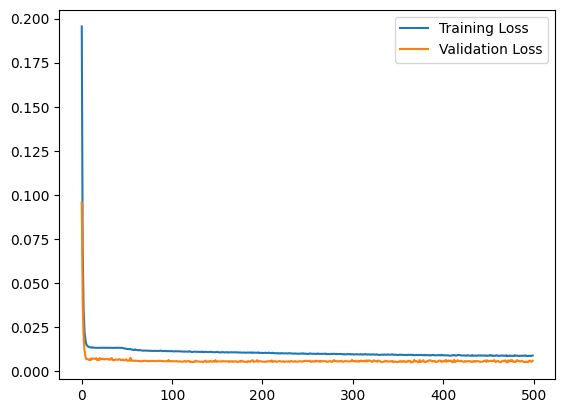

In [39]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


**Make Predictions and Rescale:**

Uses the trained model to make predictions on the validation set, then rescales the predictions and actual values back to their original scale for easier interpretation.

In [40]:
# Predict on validation set
y_pred = model.predict([X_hist_val, X_fut_val, X_static_val])

# Inverse transform if necessary (since we scaled the target)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_val_rescaled = scaler.inverse_transform(y_val)


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step


In [41]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val_rescaled, y_pred_rescaled)
print(f'Mean Squared Error on Validation Set: {mse}')

Mean Squared Error on Validation Set: 4.368573915666937


In [42]:
# Actual target values
y_test = y_val

In [43]:
# If y_pred and y_test are 2D arrays with shape (samples, 1), flatten them
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.flatten()

In [44]:
mse = mean_squared_error(y_test_flat, y_pred_flat)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.0059099684679308415


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_indices = y_true != 0
    y_true = y_true[nonzero_indices]
    y_pred = y_pred[nonzero_indices]
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

mape = mean_absolute_percentage_error(y_val_rescaled, y_pred_rescaled)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Percentage Error (MAPE): 98.63244476806061%


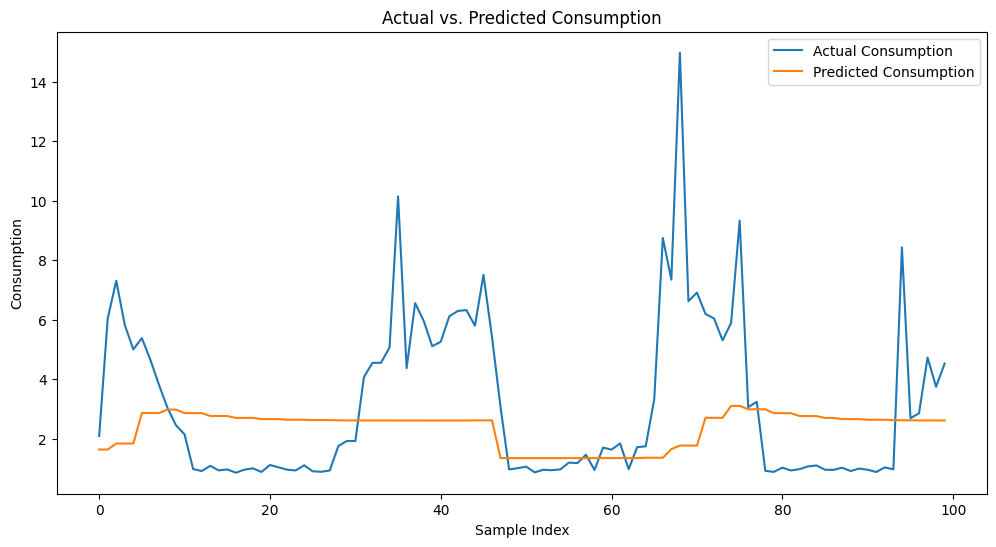

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_val_rescaled[:100], label='Actual Consumption')
plt.plot(y_pred_rescaled[:100], label='Predicted Consumption')
plt.legend()
plt.title('Actual vs. Predicted Consumption')
plt.xlabel('Sample Index')
plt.ylabel('Consumption')
plt.show()